In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [2]:
import cudf
# Load the cudf.pandas extension for pandas-like GPU acceleration
%load_ext cudf.pandas


In [3]:
import pandas as pd
from glob import glob
from numba import cuda

# Directory containing the Parquet files
data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Collect all Parquet file paths for partitions 2, 3, 4, and 5
partition_ids = [4]
parquet_files = []
for partition_id in partition_ids:
    parquet_files.extend(glob(f"{data_path}/partition_id={partition_id}/part-*.parquet"))

# Get the number of GPUs available
available_gpus = cuda.gpus
num_gpus = len(available_gpus)

if num_gpus == 0:
    raise RuntimeError("No GPUs available for processing.")

print(f"Number of GPUs available: {num_gpus}")

# Split files evenly across available GPUs
files_per_gpu = len(parquet_files) // num_gpus
gpu_file_splits = [
    parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
    for i in range(num_gpus)
]

# Adjust the last split to include any remaining files
if len(parquet_files) % num_gpus != 0:
    gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])

# Function to process files on a specific GPU
def process_files_on_gpu(files, gpu_id):
    # Select the GPU for processing
    cuda.select_device(gpu_id)
    gpu_batches = []
    for file in files:
        print(f"Processing file on GPU {gpu_id}: {file}")
        
        # Read the file into GPU memory using pandas
        gpu_df = pd.read_parquet(file)
        
        # Keep all columns, no filtering
        gpu_batches.append(gpu_df)
        
        print(f"File {file} processed on GPU {gpu_id}.")

    # Concatenate all batches for this GPU into a single DataFrame
    if gpu_batches:
        return pd.concat(gpu_batches, ignore_index=True)
    else:
        return pd.DataFrame()

# Process files on all available GPUs
final_gpu_dfs = []
for gpu_id, files in enumerate(gpu_file_splits):
    gpu_df = process_files_on_gpu(files, gpu_id)
    final_gpu_dfs.append(gpu_df)

# Combine all processed batches across GPUs into a single DataFrame
final_df = pd.concat(final_gpu_dfs, ignore_index=True)

# Print summary
print(f"Final DataFrame shape on GPU: {final_df.shape}")

Number of GPUs available: 2
Processing file on GPU 1: /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
File /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet processed on GPU 1.
Final DataFrame shape on GPU: (5022952, 93)


In [4]:
final_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,680,0,0,2.298160,0.851814,1.197591,0.219422,0.411698,2.057359,-0.542597,...,-0.304665,0.164485,-0.205231,0.191064,-1.413209,0.375675,0.929775,-1.574939,1.101371,4
1,680,0,1,3.928745,0.534441,1.079740,0.038748,0.275343,2.135057,-0.541966,...,0.089769,0.011395,0.092348,0.473781,0.397024,0.777026,0.826995,0.569681,1.986971,4
2,680,0,2,1.340433,-0.227643,0.764146,-0.243349,0.247027,2.347248,-0.478477,...,0.218281,0.060373,-0.164715,-0.132612,0.543831,-0.123519,-0.296969,0.547286,-0.049303,4
3,680,0,3,1.695526,0.267686,1.193612,-0.388798,0.030673,2.175273,-0.408371,...,-0.012298,1.047678,-0.696032,0.960062,2.328890,0.718955,2.047506,3.691308,3.031337,4
4,680,0,5,2.700766,0.952372,0.861269,-0.375405,0.259099,2.497325,-0.618828,...,-0.229585,-0.240741,-0.887929,-0.061485,0.691569,1.016049,0.103898,0.814866,2.073280,4


In [5]:
df = final_df.fillna(method="ffill")

/opt/conda/lib/python3.10/site-packages/cudf/core/frame.py:732: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  warnings.warn(


In [6]:
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,680,0,0,2.298160,0.851814,1.197591,0.219422,0.411698,2.057359,-0.542597,...,-0.304665,0.164485,-0.205231,0.191064,-1.413209,0.375675,0.929775,-1.574939,1.101371,4
1,680,0,1,3.928745,0.534441,1.079740,0.038748,0.275343,2.135057,-0.541966,...,0.089769,0.011395,0.092348,0.473781,0.397024,0.777026,0.826995,0.569681,1.986971,4
2,680,0,2,1.340433,-0.227643,0.764146,-0.243349,0.247027,2.347248,-0.478477,...,0.218281,0.060373,-0.164715,-0.132612,0.543831,-0.123519,-0.296969,0.547286,-0.049303,4
3,680,0,3,1.695526,0.267686,1.193612,-0.388798,0.030673,2.175273,-0.408371,...,-0.012298,1.047678,-0.696032,0.960062,2.328890,0.718955,2.047506,3.691308,3.031337,4
4,680,0,5,2.700766,0.952372,0.861269,-0.375405,0.259099,2.497325,-0.618828,...,-0.229585,-0.240741,-0.887929,-0.061485,0.691569,1.016049,0.103898,0.814866,2.073280,4


In [7]:
df.fillna(0, inplace=True)
df.isna().sum()

date_id         0
time_id         0
symbol_id       0
weight          0
feature_00      0
               ..
responder_5     0
responder_6     0
responder_7     0
responder_8     0
partition_id    0
Length: 93, dtype: int64

### correlation matrix and tables

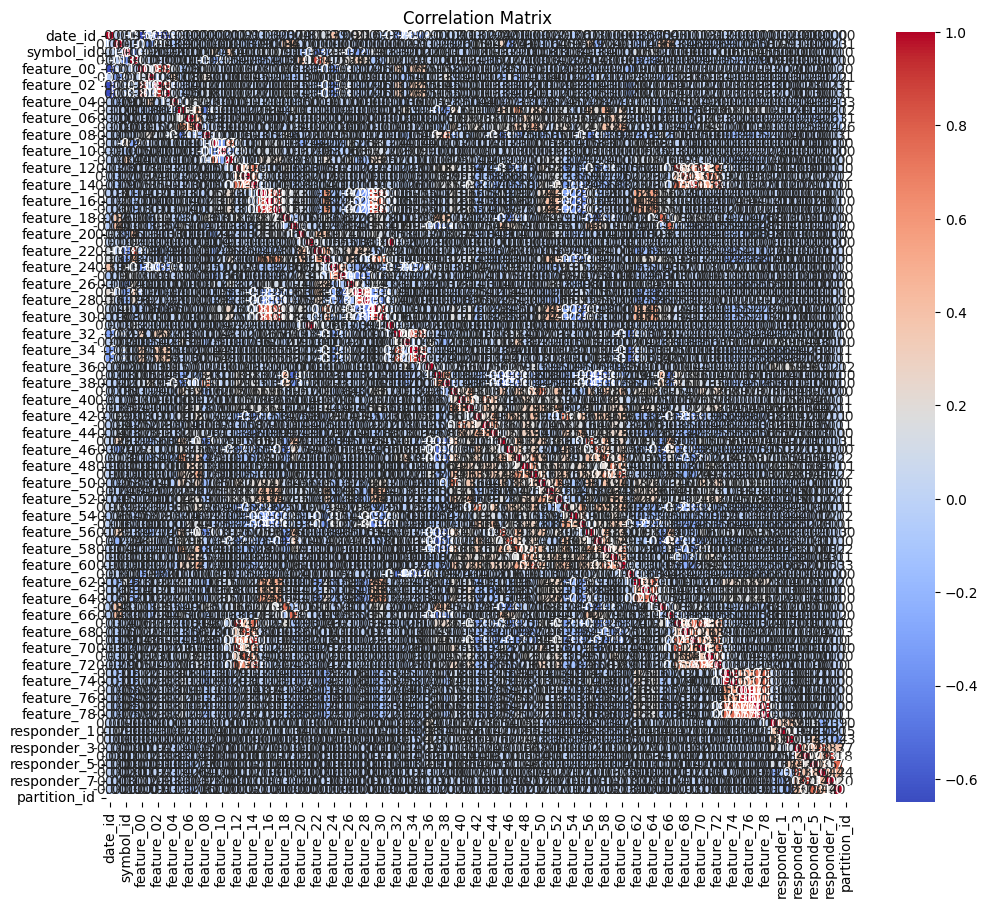

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


In [9]:
# Get the correlation of all features with 'responder_1'
correlations_with_responder_1 = correlation_matrix["responder_6"].drop("responder_6")

# Sort correlations in descending order and get the top 10 features
top_10_features = correlations_with_responder_1.abs().sort_values(ascending=False).head(40)

# Display the result
print("Top 10 Features Correlated with Responder_6:")
print(top_10_features)


Top 10 Features Correlated with Responder_6:
partition_id         NaN
responder_3     0.831614
responder_8     0.435089
responder_7     0.422456
responder_4     0.382716
responder_5     0.354057
responder_0     0.226137
responder_2     0.098918
responder_1     0.094870
feature_06      0.062949
feature_60      0.050359
feature_49      0.041424
feature_04      0.041293
feature_07      0.036564
feature_58      0.032393
feature_59      0.026889
feature_47      0.026370
feature_51      0.022870
feature_36      0.022687
feature_52      0.020888
feature_68      0.020176
feature_13      0.019408
feature_02      0.019056
feature_05      0.017863
feature_41      0.017585
feature_01      0.017119
time_id         0.016429
feature_54      0.015062
feature_40      0.014925
feature_03      0.014451
feature_55      0.013583
feature_08      0.013210
feature_19      0.012998
feature_48      0.012704
feature_00      0.012333
feature_71      0.011987
feature_66      0.011237
feature_44      0.011019
featu

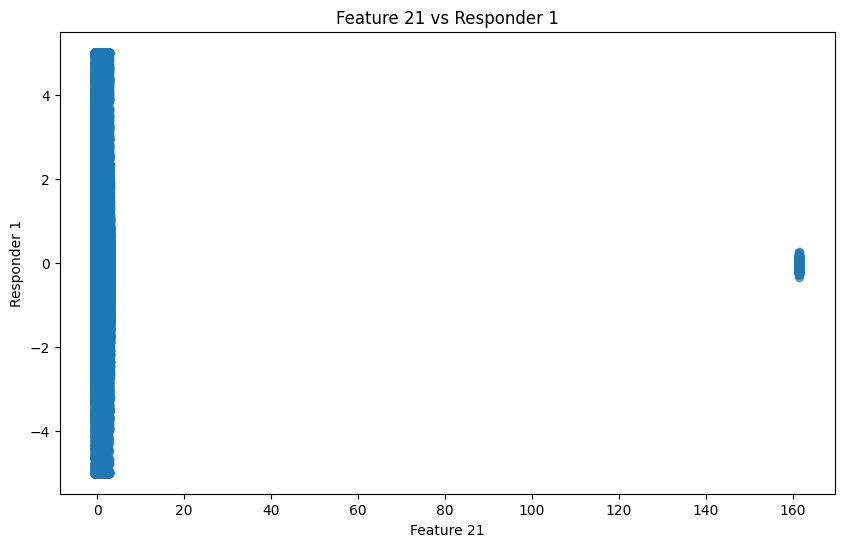

In [10]:
# Scatter plot for feature_21 vs responder_1
plt.figure(figsize=(10, 6))
plt.scatter(df['feature_21'], df['responder_1'], alpha=0.6)
plt.title('Feature 21 vs Responder 1')
plt.xlabel('Feature 21')
plt.ylabel('Responder 1')
plt.show()


### training model with 5 featrues with all access

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target
features = ['responder_3', 'responder_4', 'responder_8', 'responder_7', 'responder_5']
target = 'responder_6'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Display predictions vs actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head())


Model Coefficients: [ 1.025682   -0.25990513  0.26765588  0.2941151  -0.28746134]
Model Intercept: 0.00067264127
Mean Squared Error (MSE): 0.22156651318073273
R^2 Score: 0.7514271966254269
           Actual  Predicted
4146102 -0.087424  -0.038824
607231   0.118195  -0.284843
3550372  0.399575   0.018002
2043701 -0.081758  -0.256626
2678921  1.206762   0.348723


### training model with 5 featrues with t-1 access

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your DataFrame
# Create lagged features for t-1
df_lagged = df.copy()
lagged_features = ['responder_3', 'responder_8', 'responder_4', 'responder_7', 'responder_5']
for feature in lagged_features:
    df_lagged[f"{feature}_lagged"] = df_lagged[feature].shift(1)

# Remove rows with NaN values resulting from lagging
df_lagged.dropna(inplace=True)

# Define features (t-1) and target (t)
X = df_lagged[[f"{feature}_lagged" for feature in lagged_features]]
y = df_lagged["responder_6"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Display predictions vs actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head())


Model Coefficients: [ 0.10185958  0.02455463 -0.03031253  0.02644617 -0.01397767]
Model Intercept: 0.0003197765
Mean Squared Error (MSE): 0.8836501240730286
R^2 Score: 0.0075826711660234025
           Actual  Predicted
2234832 -0.231519  -0.010738
102258  -0.812561   0.185679
1665007 -0.061169  -0.045481
1095787 -0.109380  -0.022384
1066813  0.242614   0.078922


### training model with featrues with d-1 access

In [13]:
import os

import pandas as pd
import polars as pl
import numpy as np
import polars as pl
from glob import glob
from numba import cuda

import kaggle_evaluation.jane_street_inference_server

In [14]:
import polars as pl
from glob import glob
from numba import cuda

# Directory containing the Parquet files
data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Collect all Parquet file paths
parquet_files = glob(f"{data_path}/partition_id=0/part-0.parquet")

# partition_ids = [i for i in range(10)]
# parquet_files = [
#     f"{data_path}/partition_id={partition_id}/part-0.parquet"
#     for partition_id in partition_ids
# ]

# Get the number of GPUs available
available_gpus = cuda.gpus
num_gpus = len(available_gpus)

if num_gpus == 0:
    raise RuntimeError("No GPUs available for processing.")

print(f"Number of GPUs available: {num_gpus}")

# Split files evenly across available GPUs
files_per_gpu = len(parquet_files) // num_gpus
gpu_file_splits = [
    parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
    for i in range(num_gpus)
]

# Adjust the last split to include any remaining files
if len(parquet_files) % num_gpus != 0:
    gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])

# Function to process files on a specific GPU
def process_files_on_gpu(files, gpu_id):
    # Select the GPU for processing
    cuda.select_device(gpu_id)
    gpu_batches = []
    for file in files:
        print(f"Processing file on GPU {gpu_id}: {file}")
        
        # Read the file into GPU memory using Polars
        gpu_df = pl.read_parquet(file)
        
        # Keep all columns, no filtering
        gpu_batches.append(gpu_df)
        
        print(f"File {file} processed on GPU {gpu_id}.")

    # Concatenate all batches for this GPU into a single DataFrame
    if gpu_batches:
        return pl.concat(gpu_batches)
    else:
        return pl.DataFrame()

# Process files on all available GPUs
final_gpu_dfs = []
for gpu_id, files in enumerate(gpu_file_splits):
    gpu_df = process_files_on_gpu(files, gpu_id)
    final_gpu_dfs.append(gpu_df)

# Combine all processed batches across GPUs into a single DataFrame
final_df = pl.concat(final_gpu_dfs)

# Print summary
print(f"Final DataFrame shape on GPU: {final_df.shape}")

Number of GPUs available: 2
Processing file on GPU 1: /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet
File /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet processed on GPU 1.
Final DataFrame shape on GPU: (1944210, 92)


In [15]:
# List of high NaN features (> 1 million NaNs out of 47 million rows)
#high_nan_features = [15, 21, 26, 27, 31, 52, 53, 55, 73, 74, 0, 1, 2, 3, 4, 39, 42, 41, 50]

# Create zero-padded feature names
#drop_feats = [f"feature_{str(i).zfill(2)}" for i in high_nan_features]

# Drop the features from the DataFrame
#filtered_df = final_df.drop(drop_feats)
#filtered_df.head()

In [16]:
# Fill NaNs with forward fill
filled_df = final_df.fill_null(strategy="forward")
filled_df = final_df.fill_null(strategy="backward")
filled_df.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,-0.209974,-0.169586,-0.290429,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,0.987255,…,0.204797,1.245972,-0.588628,-0.808103,0.206227,-2.037683,0.727661,-0.059082,-0.989118,-0.345213,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,-0.354356,-0.264701,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,-0.209974,0.317467,-0.290429,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,0.987255,…,1.172836,1.245972,-0.588628,-1.625862,0.206227,-1.410017,1.063013,-0.059082,0.888355,0.467994,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,-0.354356,-0.264701,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,-0.209974,-0.814909,-0.290429,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,0.987255,…,0.535897,1.245972,-0.588628,-0.72542,0.206227,-2.29417,1.764551,-0.059082,-0.120789,-0.063458,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,-0.354356,-0.264701,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,-0.209974,-0.251882,-0.290429,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,0.987255,…,2.413415,1.245972,-0.588628,1.313203,0.206227,-0.810125,2.939022,-0.059082,3.988801,1.834661,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,-0.354356,-0.264701,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,-0.209974,0.646086,-0.290429,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,0.987255,…,1.253902,1.245972,-0.588628,0.476195,0.206227,-0.771732,2.843421,-0.059082,1.379815,0.411827,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.0832

In [17]:
final_df = filled_df

In [18]:
import polars as pl

# List of responder columns
responder_columns = [f"responder_{i}" for i in range(9)]

# Apply the lagging for each responder column
for responder in responder_columns:
    lagged_column_name = f"{responder}_lag_1"
    final_df = final_df.with_columns(
        pl.col(responder)
        .shift(1)
        .over(["time_id", "symbol_id"])
        .alias(lagged_column_name)
    )

# Display the first few rows to verify
final_df.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,-0.209974,-0.169586,-0.290429,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,0.987255,…,-0.345213,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,-0.354356,-0.264701,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,null,null,null,null,null,null,null,null,null
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,-0.209974,0.317467,-0.290429,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,0.987255,…,0.467994,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,-0.354356,-0.264701,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639,null,null,null,null,null,null,null,null,null
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,-0.209974,-0.814909,-0.290429,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,0.987255,…,-0.063458,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,-0.354356,-0.264701,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828,null,null,null,null,null,null,null,null,null
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,-0.209974,-0.251882,-0.290429,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,0.987255,…,1.834661,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,-0.354356,-0.264701,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516,null,null,null,null,null,null,null,null,null
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,-0.209974,0.646086,-0.290429,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,0.987255,…,0.411827,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,-0.354356,-0.264701,3.678076,2.793581,2.61825,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282

In [19]:
symbol_grouped = final_df.group_by(["symbol_id"])
symbol_grouped.head()

symbol_id,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i8,i16,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
33,0,0,1.663408,null,null,null,null,null,1.182569,0.206299,0.253336,-0.946356,11,7,76,-0.766347,-0.406701,-1.033553,-0.209974,1.628502,-0.290429,-1.145392,-1.682898,0.679352,null,0.767303,0.740793,-1.215067,-1.124142,null,null,-0.46222,0.263958,1.038144,null,0.987255,…,0.653575,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.856799,-0.313983,-0.510727,-0.710232,-0.222114,-0.823108,-0.354356,-0.264701,-0.347611,-0.286403,-0.399971,-0.171215,0.209253,0.182766,0.010843,1.409293,0.002821,0.147636,0.965387,-0.263765,0.280629,null,null,null,null,null,null,null,null,null
33,0,1,1.663408,null,null,null,null,null,0.852197,-0.27773,0.055526,-0.616495,11,7,76,-1.390312,-0.284393,-0.674284,-0.209974,2.479222,-0.290429,-1.390504,-1.166256,0.679352,null,0.767303,0.740793,-1.215067,-1.124142,null,null,-0.46222,0.263958,1.038144,null,0.987255,…,0.815332,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.789251,-0.483513,-0.949893,-1.152184,-0.158063,-0.649769,-0.354356,-0.264701,-0.347978,-0.290819,-0.290226,-0.216155,0.214374,0.246861,-0.051141,1.20367,-0.079811,0.087943,1.401523,-0.240412,0.181041,null,null,null,null,null,null,null,null,null
33,0,2,1.663408,null,null,null,null,null,1.125607,0.211509,0.194039,-0.788869,11,7,76,-0.906984,-0.327488,-0.776561,-0.209974,1.341418,-0.290429,-0.916544,-1.04975,0.679352,null,0.767303,0.740793,-1.215067,-1.124142,null,null,-0.46222,0.263958,1.038144,null,0.987255,…,0.547131,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.748227,-0.307048,-0.629582,-1.246022,-0.17189,-0.578686,-0.354356,-0.264701,-0.265635,-0.326711,-0.380055,-0.259715,0.182786,0.196892,-0.461171,1.718243,-0.068831,-0.007666,2.112768,-0.38584,0.53101,null,null,null,null,null,null,null,null,null
33,0,3,1.663408,null,null,null,null,null,1.385077,0.220457,0.366654,-0.903039,11,7,76,-0.804144,-0.408007,-0.681591,-0.209974,1.096811,-0.290429,-1.329172,-1.335818,0.679352,null,0.767303,0.740793,-1.215067,-1.124142,null,null,-0.46222,0.263958,1.038144,null,0.987255,…,0.326346,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.957735,-0.286171,-0.417919,-0.671086,-0.273927,-0.363697,-0.354356,-0.264701,-0.234605,-0.222965,-0.247132,-0.258319,0.259406,0.219351,-0.24094,0.976913,-0.074002,-0.040841,1.133538,-0.404905,0.295483,null,null,null,null,null,null,null,null,null
33,0,4,1.663408,null,null,null,null,null,1.067505,0.38348,0.323181,-0.950661,11,7,76,-0.635771,0.63167,-0.563286,-0.209974,1.024907,1.408112,-0.900135,-1.315337,0.679352,null,0.767303,0.740793,-1.215067,-1.124142,null,null,-0.46222,0.263958,1.038144,null,0.987255,…,0.596018,-1.36224,0.414762,0.855753,0.466894,-1.025415,-1.083296,-0.601359,0.397733,-0.516422,-1.035623,0.584964,-0.495901,-0.354356,-0.264701,-0.184557,-0.292099,-0.254944,-0.227832,-1.402216,-0.47069,-2.315289,-0.43122,-0.758813,-

In [20]:
df = final_df.clone()


In [21]:
df = df.drop_nulls()

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the selected features and lagged responders
selected_features = [
    'responder_3_lag_1', 'responder_8_lag_1', 'responder_7_lag_1', 'responder_4_lag_1', 'responder_5_lag_1',
    'responder_0_lag_1', 'responder_2_lag_1', 'responder_1_lag_1', 
    'feature_06', 'feature_60', 'feature_49', 'feature_04', 'feature_07', 
    'feature_58', 'feature_59', 'feature_47', 'feature_51', 'feature_36', 
    'feature_52', 'feature_68', 'feature_13', 'feature_02', 'feature_05', 
    'feature_41', 'feature_01', 'time_id', 'feature_54', 'feature_40', 
    'feature_03', 'feature_55', 'feature_08', 'feature_19', 'feature_48', 
    'feature_00', 'feature_71', 'feature_66', 'feature_44', 'feature_45', 'feature_53'
]

# Ensure these features exist in the DataFrame
if not all(feature in df.columns for feature in selected_features):
    missing_features = [feature for feature in selected_features if feature not in df.columns]
    raise ValueError(f"Missing features in the DataFrame: {missing_features}")

# Define the feature set and target variable
X = df[selected_features]
y = df["responder_6"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model details and evaluation metrics
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Display predictions vs actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head())


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### printing and checking for each paraque file for each parition then seeing the results 

In [ ]:
import os

import pandas as pd
import polars as pl
import numpy as np
import polars as pl
from glob import glob
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import kaggle_evaluation.jane_street_inference_server

In [ ]:
for k in range(3,10):


    # Directory containing the Parquet files
    data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
    
    # Collect all Parquet file paths
    parquet_files = glob(f"{data_path}/partition_id={k}/part-0.parquet")
    
    # Get the number of GPUs available
    available_gpus = cuda.gpus
    num_gpus = len(available_gpus)
    
    if num_gpus == 0:
        raise RuntimeError("No GPUs available for processing.")
    
    print(f"Number of GPUs available: {num_gpus}")
    
    # Split files evenly across available GPUs
    files_per_gpu = len(parquet_files) // num_gpus
    gpu_file_splits = [
        parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
        for i in range(num_gpus)
    ]
    
    # Adjust the last split to include any remaining files
    if len(parquet_files) % num_gpus != 0:
        gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])
    
    # Function to process files on a specific GPU
    def process_files_on_gpu(files, gpu_id):
        # Select the GPU for processing
        cuda.select_device(gpu_id)
        gpu_batches = []
        for file in files:
            print(f"Processing file on GPU {gpu_id}: {file}")
            
            # Read the file into GPU memory using Polars
            gpu_df = pl.read_parquet(file)
            
            # Keep all columns, no filtering
            gpu_batches.append(gpu_df)
            
            print(f"File {file} processed on GPU {gpu_id}.")
    
        # Concatenate all batches for this GPU into a single DataFrame
        if gpu_batches:
            return pl.concat(gpu_batches)
        else:
            return pl.DataFrame()
    
    # Process files on all available GPUs
    final_gpu_dfs = []
    for gpu_id, files in enumerate(gpu_file_splits):
        gpu_df = process_files_on_gpu(files, gpu_id)
        final_gpu_dfs.append(gpu_df)
    
    # Combine all processed batches across GPUs into a single DataFrame
    final_df = pl.concat(final_gpu_dfs)
    
    # Print summary
    print(f"Final DataFrame shape on GPU: {final_df.shape}")
    
    # Fill NaNs with forward fill
    filled_df = final_df.fill_null(strategy="forward")
    filled_df = final_df.fill_null(strategy="backward")
    filled_df.head()
    
    import polars as pl
    
    # List of responder columns
    responder_columns = [f"responder_{i}" for i in range(9)]
    
    # Apply the lagging for each responder column
    for responder in responder_columns:
        lagged_column_name = f"{responder}_lag_1"
        final_df = final_df.with_columns(
            pl.col(responder)
            .shift(1)
            .over(["time_id", "symbol_id"])
            .alias(lagged_column_name)
        )
    
    # Display the first few rows to verify
    final_df.head()
    
    symbol_grouped = final_df.group_by(["symbol_id"])
    symbol_grouped.head()
    
    df = final_df.clone()
    
    df = df.drop_nulls()
    
    
    
    # Define the selected features and lagged responders
    selected_features = [
        'responder_3_lag_1', 'responder_8_lag_1', 'responder_7_lag_1', 'responder_4_lag_1', 'responder_5_lag_1',
        'responder_0_lag_1', 'responder_2_lag_1', 'responder_1_lag_1', 
        'feature_06', 'feature_60', 'feature_49', 'feature_04', 'feature_07', 
        'feature_58', 'feature_59', 'feature_47', 'feature_51', 'feature_36', 
        'feature_52', 'feature_68', 'feature_13', 'feature_02', 'feature_05', 
        'feature_41', 'feature_01', 'time_id', 'feature_54', 'feature_40', 
        'feature_03', 'feature_55', 'feature_08', 'feature_19', 'feature_48', 
        'feature_00', 'feature_71', 'feature_66', 'feature_44', 'feature_45', 'feature_53'
    ]
    
    # Ensure these features exist in the DataFrame
    if not all(feature in df.columns for feature in selected_features):
        missing_features = [feature for feature in selected_features if feature not in df.columns]
        raise ValueError(f"Missing features in the DataFrame: {missing_features}")
    
    # Define the feature set and target variable
    X = df[selected_features]
    y = df["responder_6"]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create the linear regression model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print model details and evaluation metrics
    print("Model Coefficients:", model.coef_)
    print("Model Intercept:", model.intercept_)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R^2 Score: {r2}")
    
    # Display predictions vs actual values
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(results.head())


In [ ]:
import pickle
import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from glob import glob

# Initialize variables
saved_model_path = "saved_model.pkl"  # Path to save the model
is_first_run = True  # To track if it's the first partition

for k in range(3, 10):

    # Directory containing the Parquet files
    data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
    
    # Collect all Parquet file paths
    parquet_files = glob(f"{data_path}/partition_id={k}/part-0.parquet")
    
    # Get the number of GPUs available
    available_gpus = cuda.gpus
    num_gpus = len(available_gpus)
    
    if num_gpus == 0:
        raise RuntimeError("No GPUs available for processing.")
    
    print(f"Number of GPUs available: {num_gpus}")
    
    # Split files evenly across available GPUs
    files_per_gpu = len(parquet_files) // num_gpus
    gpu_file_splits = [
        parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
        for i in range(num_gpus)
    ]
    
    # Adjust the last split to include any remaining files
    if len(parquet_files) % num_gpus != 0:
        gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])
    
    # Function to process files on a specific GPU
    def process_files_on_gpu(files, gpu_id):
        # Select the GPU for processing
        cuda.select_device(gpu_id)
        gpu_batches = []
        for file in files:
            print(f"Processing file on GPU {gpu_id}: {file}")
            
            # Read the file into GPU memory using Polars
            gpu_df = pl.read_parquet(file)
            
            # Keep all columns, no filtering
            gpu_batches.append(gpu_df)
            
            print(f"File {file} processed on GPU {gpu_id}.")
    
        # Concatenate all batches for this GPU into a single DataFrame
        if gpu_batches:
            return pl.concat(gpu_batches)
        else:
            return pl.DataFrame()
    
    # Process files on all available GPUs
    final_gpu_dfs = []
    for gpu_id, files in enumerate(gpu_file_splits):
        gpu_df = process_files_on_gpu(files, gpu_id)
        final_gpu_dfs.append(gpu_df)
    
    # Combine all processed batches across GPUs into a single DataFrame
    final_df = pl.concat(final_gpu_dfs)
    
    # Print summary
    print(f"Final DataFrame shape on GPU: {final_df.shape}")
    
    # Fill NaNs with forward fill
    filled_df = final_df.fill_null(strategy="forward")
    filled_df = final_df.fill_null(strategy="backward")
    filled_df.head()
    
    # List of responder columns
    responder_columns = [f"responder_{i}" for i in range(9)]
    
    # Apply the lagging for each responder column
    for responder in responder_columns:
        lagged_column_name = f"{responder}_lag_1"
        final_df = final_df.with_columns(
            pl.col(responder)
            .shift(1)
            .over(["time_id", "symbol_id"])
            .alias(lagged_column_name)
        )
    
    # Display the first few rows to verify
    final_df.head()
    
    symbol_grouped = final_df.group_by(["symbol_id"])
    symbol_grouped.head()
    
    df = final_df.clone()
    
    df = df.drop_nulls()
    
    # Define the selected features and lagged responders
    selected_features = [
        'responder_3_lag_1', 'responder_8_lag_1', 'responder_7_lag_1', 'responder_4_lag_1', 'responder_5_lag_1',
        'responder_0_lag_1', 'responder_2_lag_1', 'responder_1_lag_1', 
        'feature_06', 'feature_60', 'feature_49', 'feature_04', 'feature_07', 
        'feature_58', 'feature_59', 'feature_47', 'feature_51', 'feature_36', 
        'feature_52', 'feature_68', 'feature_13', 'feature_02', 'feature_05', 
        'feature_41', 'feature_01', 'time_id', 'feature_54', 'feature_40', 
        'feature_03', 'feature_55', 'feature_08', 'feature_19', 'feature_48', 
        'feature_00', 'feature_71', 'feature_66', 'feature_44', 'feature_45', 'feature_53'
    ]
    
    # Ensure these features exist in the DataFrame
    if not all(feature in df.columns for feature in selected_features):
        missing_features = [feature for feature in selected_features if feature not in df.columns]
        raise ValueError(f"Missing features in the DataFrame: {missing_features}")
    
    # Define the feature set and target variable
    X = df[selected_features]
    y = df["responder_6"]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Load the model if not the first run, else create a new one
    if not is_first_run:
        with open(saved_model_path, "rb") as f:
            model = pickle.load(f)
    else:
        model = LinearRegression()
        is_first_run = False  # After the first initialization
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Save the updated model
    with open(saved_model_path, "wb") as f:
        pickle.dump(model, f)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print model details and evaluation metrics
    print(f"Partition {k} - Model Coefficients:", model.coef_)
    print(f"Partition {k} - Model Intercept:", model.intercept_)
    print(f"Partition {k} - Mean Squared Error (MSE): {mse}")
    print(f"Partition {k} - R^2 Score: {r2}")
    
    # Display predictions vs actual values
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(results.head())


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df is your DataFrame containing responder_6
# Replace this with actual loading code if required
# df = pd.read_csv("your_data.csv")  # Example loading if not already loaded

# Extract responder_6 values
responder_6_values = df["responder_6"]

# Plot the PDF of responder_6 values
plt.figure(figsize=(12, 6))
plt.hist(responder_6_values, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title("Probability Density Function of Responder 6")
plt.xlabel("Responder 6 Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Calculate the range where 90% of values lie
lower_bound = np.percentile(responder_6_values, 20)
upper_bound = np.percentile(responder_6_values, 80)

print(f"90% of the values of Responder 6 lie between {lower_bound} and {upper_bound}.")


In [ ]:
95% of the values of Responder 6 lie between -1.4062880277633667 and 1.4500611066818234.
